Part 2 - Q4 - Fine Tuning Strategies
===



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tsfresh as tsf
from tsfresh import extract_features
import warnings

In [2]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [4]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [5]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

2024-05-20 21:21:46.221422: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 21:21:47.793921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 21:21:52.413431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
format_dict = par.create_format_dict()

In [7]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(False, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(False, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [8]:
# df_heart = pd.read_csv('../data_proj2/ptbdb_train.csv')
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [9]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_heart_train.shape

(11641, 188)

## Labels

In [11]:
label_col = list(df_heart_train.columns)[-1]
labels_count = df_heart_train[label_col].value_counts(normalize=True).to_frame().T
labels_count.columns = [str(x) for x in labels_count.columns]
n_classes = len(labels_count.columns)
labels_count.style.format(format_dict)

,1.0,0.0
proportion,72%,28%


/home/pinolej/eth/healthcare/proj3/task_1/graph.py:146: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


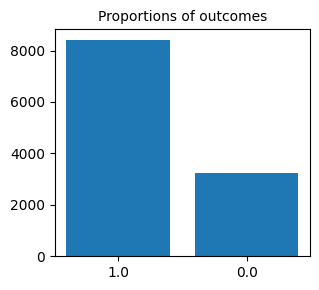

In [12]:
gr.dist_mult_plots(
    df_heart_train,
    cols=[label_col],
		rename_cols_for_title={label_col: 'Proportions of outcomes'},
    figsize=(6, 3),
    ncols=2,
    bar_plot=True,
    fontsize={
        'ax_title': 10,
    },
)

In [13]:
x_train_0, x_test_0, y_train_0, y_test_0 = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=True,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
)

# Question 1: Classic ML Models

## B/ Encoder from question 2


In [ ]:
from tensorflow.keras.models import load_model

# Load the pre-trained encoder
encoder_model = load_model('encoder_model.h5')

for layer in encoder_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Define the input for the new model
new_inputs = encoder_model.input

# Pass the encoder output to a new dense layer for classification
x = encoder_model.output
x = Dense(10, activation='softmax')(x)  # Example for a 10-class classification problem

# Create the new model
new_model = Model(inputs=new_inputs, outputs=x)

# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [142]:
# Step 5: Fine-Tuning with Supervised Learning
# Use the learned encoder and add a classification head
encoded_inputs = layers.Input(shape=(n_neurons,))
classification_output = layers.Dense(num_classes, activation='softmax')(encoded_inputs)
classification_model = models.Model(encoded_inputs, classification_output)

# Freeze the encoder weights and create a full model
encoder.trainable = False
full_input = layers.Input(shape=(seq_length, input_dim))
encoded_output = encoder(full_input)
classification_output = classification_model(encoded_output)
full_model = models.Model(full_input, classification_output)

# Compile and train the full model with labels
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# full_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = full_model.fit(
	x_train_0_subset,
	y_train_0_subset,
	batch_size=batch_size,
	epochs=12,
	validation_split=0.2,
	)

Epoch 1/12
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.7927 - loss: 1.2167 - val_accuracy: 0.8268 - val_loss: 0.6856
Epoch 2/12
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.8243 - loss: 0.6587 - val_accuracy: 0.8268 - val_loss: 0.5985
Epoch 3/12
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.8268 - loss: 0.5839 - val_accuracy: 0.8268 - val_loss: 0.5585
Epoch 4/12
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.8273 - loss: 0.5466 - val_accuracy: 0.8268 - val_loss: 0.5294
Epoch 5/12
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.8237 - loss: 0.5240 - val_accuracy: 0.8302 - val_loss: 0.5062
Epoch 6/12
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.8340 - loss: 0.4953 - val_accuracy: 0.8399 - val_loss: 0.4868
Epoch 7/12
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.8415 - loss: 0.4792 - val_accuracy: 0.8495 - val_loss: 0.4706
Epoch 8/12
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.8516 -

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'],'--')
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='lower right')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'],"--")
axes[1].set_title('model loss')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['val_loss', 'loss'], loc='lower right')

array([0., 0., 1., 0., 0.])

## Evaluation

In [ ]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [ ]:
x_eval, _, y_eval, _, torch_input = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
				output_torch_for_eval=True,
)

In [ ]:
y_pred_proba = full_model.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [ ]:
y_pred_class_df.value_counts()

0    18421
4     1573
2     1474
1      369
3       55
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import f1_score
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,97.3%,76.2%,81.7%


In [ ]:
classes_correspondances = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
classes_correspondances_inverted = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}
list_for_graph_labels = []
for i in range(5):
	list_for_graph_labels.append(str(i) + f": '{classes_correspondances_inverted[i]}'")
list_for_graph_labels

["0: 'N'", "1: 'S'", "2: 'V'", "3: 'F'", "4: 'Q'"]

Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

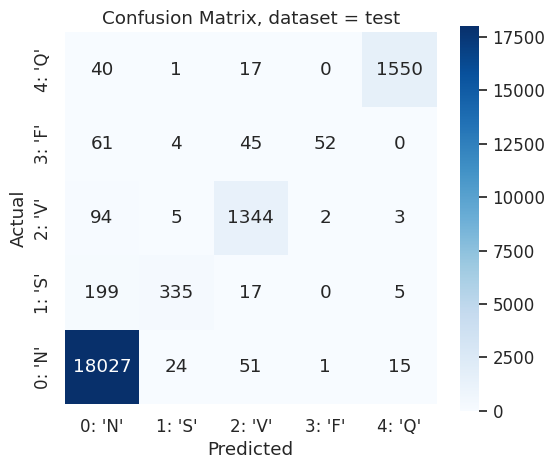

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=list_for_graph_labels,
    yticklabels=list_for_graph_labels)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
# ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [ ]:
# # equivalent to: model.save("model.h5")
# from tensorflow.keras.models import save_model
# # save_model(model, "model_second_save.h5")
# # save model and architecture to single file
# model_log.save("model_log.h5")
# model_log.save('model_log.keras')
# print("Saved model to disk")

Saved model to disk


# From the question 1 encoder?

In [ ]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [ ]:
x_eval, _, y_eval, _, torch_input = lib.pre_process_ecg(
        df_heart_test,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
				with_lstm_transfo=False,
				for_keras=True,
				n_classes=n_classes,
				output_torch_for_eval=True,
)

## Evaluation

In [ ]:
y_pred_proba = model_log.predict(x_eval)
y_pred_proba_tensor = torch.from_numpy(y_pred_proba)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_pred_class_df = pd.Series(y_pred_class)
y_pred_class_tensor = torch.from_numpy(y_pred_class)
y_true = np.argmax(y_eval, axis=1)
y_true_tensor = torch.from_numpy(y_true)

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [ ]:
y_pred_class_df.value_counts()

0    18421
4     1573
2     1474
1      369
3       55
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import f1_score
acc = accuracy_score(y_true, y_pred_class_tensor, normalize = True)  
# bal_acc=balanced_accuracy_score(y_true_tensor,y_pred_class_tensor)
bal_acc=balanced_accuracy_score(y_true,y_pred_class_tensor)
# f1_score = BinaryF1Score()
f1 = f1_score(y_pred_class, y_true, average='macro')
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,97.3%,76.2%,81.7%


In [ ]:
classes_correspondances = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
classes_correspondances_inverted = {0:'N', 1:'S', 2:'V', 3:'F', 4:'Q'}
list_for_graph_labels = []
for i in range(5):
	list_for_graph_labels.append(str(i) + f": '{classes_correspondances_inverted[i]}'")
list_for_graph_labels

["0: 'N'", "1: 'S'", "2: 'V'", "3: 'F'", "4: 'Q'"]

Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

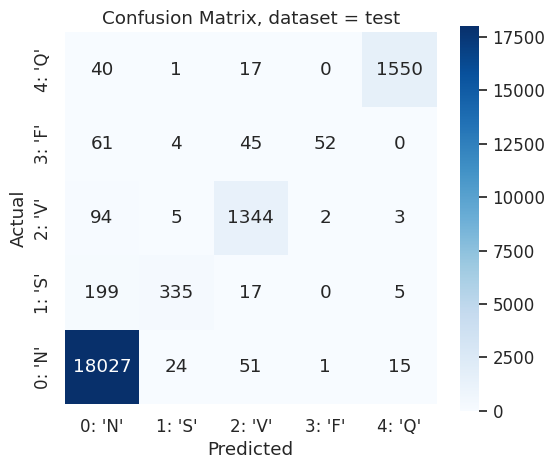

In [ ]:
logreg_conf_matrix = confusion_matrix(y_true_tensor, y_pred_class_tensor)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=list_for_graph_labels,
    yticklabels=list_for_graph_labels)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
# ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [ ]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
# save_model(model, "model_second_save.h5")
# save model and architecture to single file
model_log.save("model_log.h5")
model_log.save('model_log.keras')
print("Saved model to disk")

Saved model to disk
